In [1]:
import pandas as pd
import numpy as np
import PIL
from keras.applications import VGG16,imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import Dense
import numpy as np
import glob
import os

import pickle
import time

Using TensorFlow backend.


In [2]:
bbox = pd.read_table('Data/DeepFashion/list_bbox.txt',sep='\s+')
cat = pd.read_table('Data/DeepFashion/list_category_img.txt',sep='\s+')

In [41]:
joined = bbox.join(cat,lsuffix='_',rsuffix='')

In [72]:
joined.head()

,image_name_,x_1,y_1,x_2,y_2,image_name,category_label,code
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,2
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,2
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,2


In [71]:
joined['category_label'] = pd.Categorical(joined['category_label'])
joined['code'] = joined['category_label'].cat.codes

In [5]:
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input

def preprocess_DF(bbox):
    image = crop_resize_DF(bbox)
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    
    return preprocess(image)

def crop_resize_DF(bbox):
    img = PIL.Image.open('./Data/DeepFashion/'+bbox['image_name'])
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    
    img = img.crop((lx,ly,ux,uy))
    img = img.resize(inputShape, PIL.Image.ANTIALIAS)
    return img

In [75]:
def generator(df, batch_size):
    while True:
        subset = np.random.randint(df.shape[0],size=batch_size)
        proc_imgs = []
        for i in range(batch_size):
            proc_imgs.append(np.squeeze(preprocess_DF(df.iloc[i])))
    
        attr = df.iloc[subset]['code'].values
        yield np.array(proc_imgs), attr

In [92]:
def gen_batch(df,batch_size):
    subset = np.random.randint(df.shape[0],size=batch_size)
    proc_imgs = []
    for i in range(batch_size):
        proc_imgs.append(np.squeeze(preprocess_DF(df.iloc[i])))
    
    attr = df.iloc[subset]['code'].values
    return np.array(proc_imgs), attr

In [60]:
attr = joined['category_label'].values

In [62]:
joined.iloc[:10]['category_label'].values

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [18]:
np.bincount(attr)

array([    0,   160,  7495, 24557,   309,   330, 13311,   324,    17,
         716,  4048, 10467,   748,   676,    97,   791, 13123, 15429,
       36887, 10078,   146,    77,   527,   486,  1669,    49,  7076,
         594,    45,  4416,  5013,    32, 19666, 14773,  3048,  1106,
         386,    54,     0,  2120,    17, 72158,  6153,   126,  2294,
           0,    70,   150,  7408])

In [25]:
(classes,counts) = np.unique(attr,return_counts=True)

In [69]:
classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48])

In [26]:
class_weights = joined.shape[0]/(counts*len(classes))

In [16]:
class_weights

array([  2.89222000e+05,   3.92911289e+01,   8.38881460e-01,
         2.56034093e-01,   2.03462540e+01,   1.90515776e+01,
         4.72348021e-01,   1.94043610e+01,   3.69376756e+02,
         8.78106689e+00,   1.55321171e+00,   6.00689952e-01,
         8.40541719e+00,   9.30063993e+00,   6.48043917e+01,
         7.94849809e+00,   4.79114865e-01,   4.07507027e-01,
         1.70451137e-01,   6.23875890e-01,   4.30582105e+01,
         8.16319503e+01,   1.19301242e+01,   1.29365299e+01,
         3.76713774e+00,   1.28258093e+02,   8.88555040e-01,
         1.05845197e+01,   1.39653308e+02,   1.42377804e+00,
         1.25422053e+00,   1.96348948e+02,   3.19710558e-01,
         4.25602486e-01,   2.06279197e+00,   5.68472984e+00,
         1.62877738e+01,   1.16387123e+02,   2.89222000e+05,
         2.96574071e+00,   3.69376756e+02,   8.71342455e-02,
         1.02184505e+00,   4.98916681e+01,   2.74079128e+00,
         2.89222000e+05,   8.97926110e+01,   4.19101579e+01,
         8.48733306e-01]

In [79]:
base_model = VGG16(weights='imagenet')
x = base_model.get_layer('fc2').output
predictions = Dense(len(classes), activation='softmax',name='predictions')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

for layer in new_model.layers[:19]:
    layer.trainable = False


new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics = ['sparse_top_k_categorical_accuracy'])

In [81]:
from keras import callbacks
tbCB = callbacks.TensorBoard(log_dir="logs/{}".format(time.time()), histogram_freq=0, write_graph=False, write_images=False)
checkpointCB = callbacks.ModelCheckpoint("checkpoints/{}".format(time.time()))

h = new_model.fit_generator(generator(joined,64),steps_per_epoch=1000,epochs=1,verbose=1,callbacks=[tbCB,checkpointCB],class_weight=class_weights)

Epoch 1/1
1000/1000 [==============================] - 30960s - loss: 14.0746 - sparse_top_k_categorical_accuracy: 1.0000  


In [82]:
p = new_model.predict_generator(generator(joined,64),steps=1)

In [85]:
np.argmax(p,axis=1)

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

In [87]:
counts[17]/np.sum(counts)

0.12753870729059338

<Container object of 46 artists>

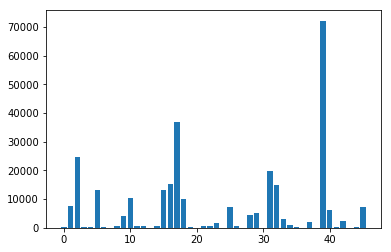

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(np.arange(len(counts)),counts)

In [93]:
X, Y = gen_batch(joined,64)

In [95]:
p = new_model.predict(X)

In [96]:
np.argmax(p,axis=1)

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

(array([  5.,   2.,   4.,  18.,   0.,   4.,   6.,   5.,  18.,   2.]),
 array([  1. ,   5.4,   9.8,  14.2,  18.6,  23. ,  27.4,  31.8,  36.2,
         40.6,  45. ]),
 <a list of 10 Patch objects>)

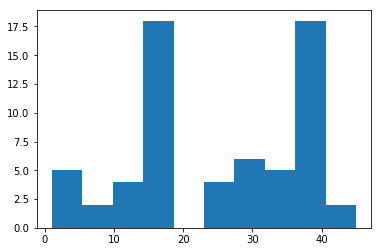

In [98]:
plt.hist(Y)